# Importing Dataset

In [1]:
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [2]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


# Libraries :

In [3]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

# Spilitting Dataset

In [4]:
base_path = "data"
words_list = []

words = open("data/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # checking for errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [5]:
(words_list[0:10])

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure\n',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he\n',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during\n',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of\n',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty\n',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy\n',
 'n03-082-04-03 ok 165 992 1414 118 135 NN boy\n',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The\n',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and\n',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in\n']

In [6]:
len(words_list)

96456

In [7]:
# split the dataset into three subsets with a 90:5:5 ratio (train:validation:test)
split_idx = int(0.9 * len(words_list)) # for defining
train_samples = words_list[:split_idx] # 90% for trainig
test_samples = words_list[split_idx:]   # remaining from testing

val_split_idx = int(0.5 * len(test_samples))  # 5% from testing for validation
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [8]:
base_image_path = os.path.join(base_path, "words")
print(base_path)
# Extracting informations and labels

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip() # splitting the data line by line
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

data


In [9]:
train_img_paths[0:10]   # gives vcomplete path of an image

['data/words/e04/e04-030/e04-030-04-08.png',
 'data/words/k02/k02-102/k02-102-05-03.png',
 'data/words/a01/a01-082u/a01-082u-01-04.png',
 'data/words/m01/m01-000/m01-000-07-00.png',
 'data/words/g01/g01-031/g01-031-07-06.png',
 'data/words/f07/f07-081b/f07-081b-01-06.png',
 'data/words/n03/n03-082/n03-082-04-03.png',
 'data/words/g06/g06-018c/g06-018c-04-05.png',
 'data/words/g06/g06-011j/g06-011j-06-06.png',
 'data/words/f04/f04-024/f04-024-01-06.png']

In [10]:
train_labels[0:10] # also provides the content of the image

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy',
 'n03-082-04-03 ok 165 992 1414 118 135 NN boy',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in']

In [11]:
validation_img_paths[0:10]

['data/words/b01/b01-136/b01-136-01-01.png',
 'data/words/a04/a04-019/a04-019-05-11.png',
 'data/words/g04/g04-088/g04-088-05-05.png',
 'data/words/c03/c03-096d/c03-096d-07-03.png',
 'data/words/r03/r03-035/r03-035-04-05.png',
 'data/words/j04/j04-035/j04-035-05-03.png',
 'data/words/b04/b04-000/b04-000-03-03.png',
 'data/words/p03/p03-069/p03-069-03-06.png',
 'data/words/k02/k02-029/k02-029-05-03.png',
 'data/words/j04/j04-015/j04-015-04-07.png']

In [12]:
validation_labels[0:10]

['b01-136-01-01 ok 182 511 915 132 91 JJ able',
 'a04-019-05-11 ok 172 2060 1802 93 117 JJ full',
 'g04-088-05-05 ok 172 1375 1678 6 5 . .',
 'c03-096d-07-03 ok 169 978 2036 140 62 VB act',
 'r03-035-04-05 ok 204 998 1449 143 120 PP2 you',
 'j04-035-05-03 ok 169 1004 1666 306 57 JJ National',
 'b04-000-03-03 ok 182 1100 1234 19 6 *- -',
 'p03-069-03-06 ok 203 1403 1305 140 85 NN abyss',
 'k02-029-05-03 ok 182 754 1807 152 53 VBD said',
 'j04-015-04-07 ok 174 2092 1449 59 75 IN in']

In [13]:
# since the information provided is not so necessary whereas the needed informtion is the content or the word

In [14]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip() # will go to each label and filter or extact only the word from the label information
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)   # how many maximum aphabets are present in single word
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [15]:
# clean the validation and the test labels as well.
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

# Building Block

In [16]:

AUTOTUNE = tf.data.AUTOTUNE  # tunes tf.data to the value dynamically at runtime
# char to num using keras library that is if you give any string data it will convert into mathematical array
# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)


# num to char using keras library that is if you give any mathematical  data it will convert into string
# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

# Resizing images without distortion
* Aspect ratio is preserved.
* Content of the images is not affected.

In [17]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

# PADDING
    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    # after padding flipping and transposing the image to improve the accuracy
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


In [18]:
# Combining features
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

# converting into mathematical aaray
def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size) # function calling
    image = tf.cast(image, tf.float32) / 255.0
    return image

# now the text fie takes each word and it will convert it into array format and give label as an output
def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE) # batching


In [19]:
# Preparing Objects
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned) # calling prepare_dataset function and passsing variables
# when passing an image it should return the mathematical array and batch that it with its proper label
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

# Visualizing Samples

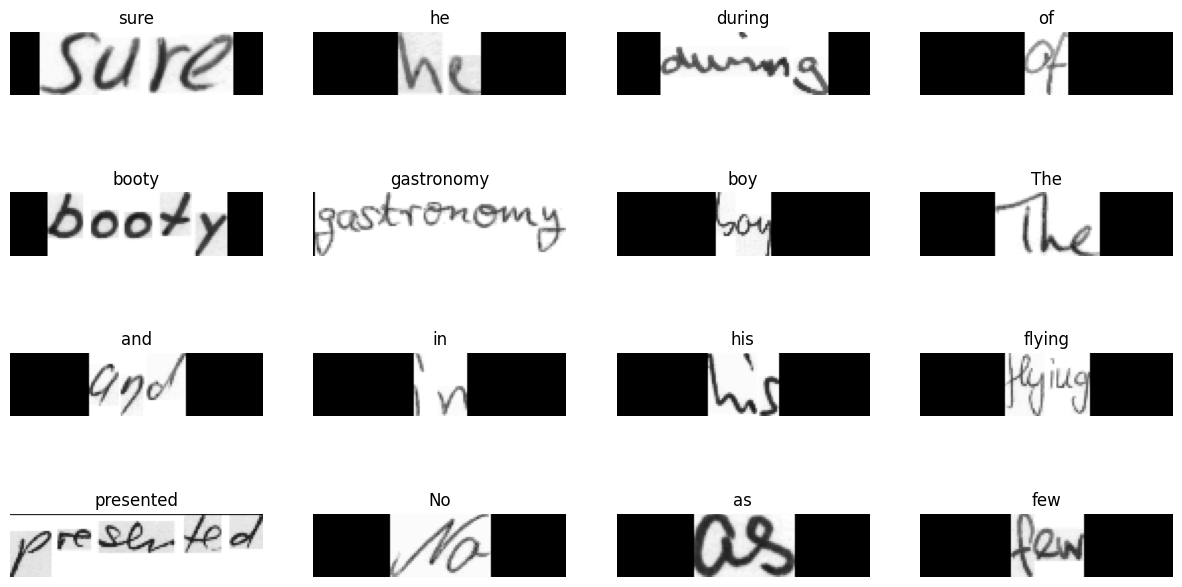

In [20]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()
# once the information is batched we will be feeding this information to the model

# Model

In [21]:

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

#Evaluation Metrics

In [22]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [23]:
# it displays some error information or lost information
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


#Training

In [24]:
epochs = 100

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
Mean edit distance for epoch 37: 17.3534
1357/1357 [==============================] - 96s 71ms/step - loss: 1.8315 - val_loss: 1.8048
Epoch 38/100
1/1 [==============================] - 0s 23ms/step
Mean edit distance for epoch 38: 17.3719
1357/1357 [==============================] - 99s 73ms/step - loss: 1.8043 - val_loss: 1.7859
Epoch 39/100
1/1 [==============================] - 0s 35ms/step
Mean edit distance for epoch 39: 17.3537
1357/1357 [==============================] - 98s 73ms/step - loss: 1.7798 - val_loss: 1.8551
Epoch 40/100
1/1 [==============================] - 0s 46ms/step
Mean edit distance for epoch 40: 17.3651
1357/1357 [==============================] - 99s 73ms/step - loss: 1.7719 - val_loss: 1.7983
Epoch 41/100
1/1 [==============================] - 0s 23ms/step
Mean edit distance for epoch 41: 17.3402
1357/1357 [==============================] - 99s 73ms/step -

2/2 [==============================] - 0s 11ms/step


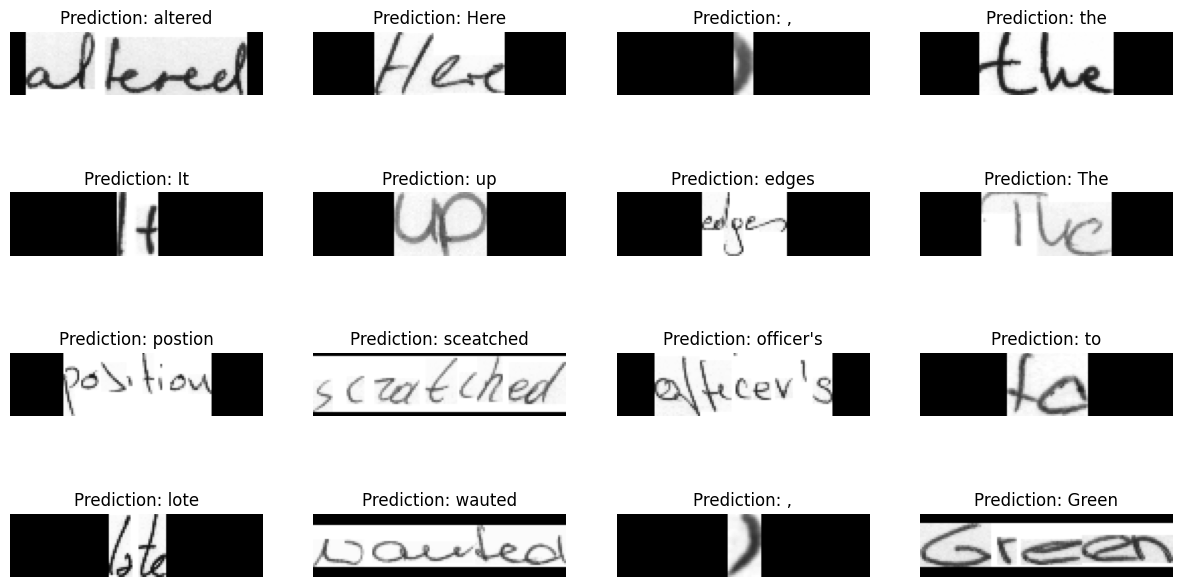

In [58]:
# Applying model on the testing data
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()


In [60]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [61]:
# Saving the model

model.save_weights('/content/drive/MyDrive/OCR-Handwriting Recognition/ocr_modelmy_v4.h5')
prediction_model.save_weights('/content/drive/MyDrive/OCR-Handwriting Recognition/ocr_modelmy_v5.h5')

# Below is working saved models
model.save("/content/drive/MyDrive/OCR-Handwriting Recognition/ocr_modelmy_v8.h5")
prediction_model.save("/content/drive/MyDrive/OCR-Handwriting Recognition/ocr_model_100_epoch.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
